In [ ]:
'''
This notebook plots PRO-seq data around splice site windows.
Figure4
'''

In [213]:
import os

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import itertools
import scipy
import pysam
import pybedtools
from pybedtools import BedTool

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

In [214]:
# link to PROseq read density around splice site windows
proseq_windows = pd.read_csv('PROseq_read_density_SpliceSiteWindows.txt', sep = '\t')
# change column names for input file
proseq_windows.columns = ['upstream5', 'junction5', 'downstream5', 'upstream3', 'junction3', 'downstream3']

In [216]:
# rearrange dataframe so it can be plotted
# Melt PROseq read density dataframe from wide to long format
proseq_windows_long = proseq_windows.melt(value_vars = ['upstream5', 'junction5', 'downstream5', 'upstream3', 'junction3', 'downstream3'])

# add column for 5SS or 3SS to facet by
proseq_windows_long['splice_site'] = pd.np.where(proseq_windows_long['variable'].str.contains("5"), "5'SS", "3'SS")

# add column for upstream, downstream, or junction
conditions = [proseq_windows_long['variable'].str.contains('upstream'),
              proseq_windows_long['variable'].str.contains('downstream'),
              proseq_windows_long['variable'].str.contains('junction')]

labels = ['upstream', 'downstream', 'junction']

proseq_windows_long['window'] = np.select(conditions, labels, np.NaN) # window label based on 'variable' column

# make window label categorical so it is plotted in the correct order
cat_type = CategoricalDtype(categories=['upstream', 'junction', 'downstream'], ordered=True) # turn category column into a category variable in order to control order of plotting
proseq_windows_long['window'] = proseq_windows_long['window'].astype(cat_type)

cat_type_junction = CategoricalDtype(categories=["5'SS", "3'SS"], ordered=True) # turn splice site column into a category variable in order to control order of plotting
proseq_windows_long['splice_site'] = proseq_windows_long['splice_site'].astype(cat_type_junction)

### Figure 4B

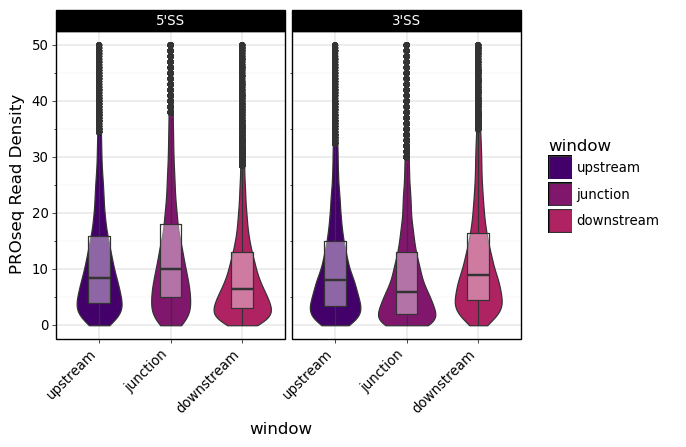

<ggplot: (8795371956701)>

In [217]:
my_colours = ['#43006A', '#81176D', '#B02363']
plt_proseq_ss_windows = (ggplot
     (data=proseq_windows_long, mapping=aes( x='window', y = 'value', fill = 'window')) +
      facet_wrap(facets = 'splice_site') +
      geom_violin(width = 0.8) +
      geom_boxplot(width = 0.3, fill = 'white', alpha = 0.4) +
      theme_linedraw(base_size = 12) +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(figure_size = (6,4)) +
#       xlab('CoSE (Long-Read Seq)') +
      ylab('PROseq Read Density') +
      ylim(0,50) +
      scale_fill_manual(values = my_colours)
           )
plt_proseq_ss_windows

In [218]:
# Statistical tests for PROseq read densitites (can do these on the input file in wide format most easily)
p_upstream5_junction5 = scipy.stats.ttest_rel(proseq_windows['upstream5'], proseq_windows['junction5'])[1]
p_upstream5_downstream5 = scipy.stats.ttest_rel(proseq_windows['upstream5'], proseq_windows['downstream5'])[1]

p_upstream3_junction3 = scipy.stats.ttest_rel(proseq_windows['upstream3'], proseq_windows['junction3'])[1]
p_upstream3_downstream3 = scipy.stats.ttest_rel(proseq_windows['upstream3'], proseq_windows['downstream3'])[1]

print("p-value 5'SS upstream vs junction = " + str(p_upstream5_junction5))
print("p-value 5'SS upstream vs downstream = " + str(p_upstream5_downstream5))
print("p-value 3'SS upstream vs junction = " + str(p_upstream3_junction3))
print("p-value 3'SS upstream vs downstream = " + str(p_upstream3_downstream3))

p-value 5'SS upstream vs junction = 0.01931662973030425
p-value 5'SS upstream vs downstream = 2.2354580496686518e-41
p-value 3'SS upstream vs junction = 1.372328012662401e-21
p-value 3'SS upstream vs downstream = 0.12384670201349503


### Save Output Figures

In [219]:
plt_proseq_ss_windows.save('PROseq_signals_around_splice_sites.pdf') # Fig 4B